In [1]:
import pandas as pd
import os
os.environ["KAGGLEHUB_CACHE_DIR"] = os.getcwd()
os.getcwd()

'C:\\Users\\yashr\\d2l-en\\jupyter-ntbks-7-onwards'

In [2]:
import kagglehub
path = kagglehub.dataset_download("vasilis73/ftse-100-index")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\yashr\.cache\kagglehub\datasets\vasilis73\ftse-100-index\versions\1


In [3]:
df = pd.read_csv(os.path.join(path,'ftse.csv'))
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,03/03/2017,7382.399902,7382.399902,7353.600098,7374.299805,7374.299805,850603100
1,06/03/2017,7374.299805,7374.299805,7338.899902,7350.100098,7350.100098,738066600
2,07/03/2017,7350.100098,7363.700195,7335.299805,7339.000000,7339.000000,844760300
3,08/03/2017,7339.000000,7354.500000,7315.899902,7334.600098,7334.600098,866234700
4,09/03/2017,7334.600098,7336.299805,7263.600098,7315.000000,7315.000000,1045803400
5,10/03/2017,7315.000000,7373.000000,7315.000000,7343.100098,7343.100098,919722100
6,13/03/2017,7343.100098,7377.399902,7342.000000,7367.100098,7367.100098,687295500
7,14/03/2017,7367.100098,7386.200195,7339.299805,7357.899902,7357.899902,842511400
8,15/03/2017,7357.899902,7383.299805,7357.600098,7368.600098,7368.600098,833084500
9,16/03/2017,7368.600098,7444.600098,7368.600098,7416.000000,7416.000000,1082219200


In [4]:
df = df.drop(['High','Low','Close','Adj Close','Volume'],axis=1)

In [5]:
df.head()

,Date,Open
0,03/03/2017,7382.399902
1,06/03/2017,7374.299805
2,07/03/2017,7350.100098
3,08/03/2017,7339.000000
4,09/03/2017,7334.600098


In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from torch.utils.data import TensorDataset, DataLoader, random_split

In [7]:
class FTSEData(d2l.DataModule):
    
    def __init__(self,df,window_size=3,batch_size=32,train_size=200):
        self.window_size = window_size
        self.batch_size = batch_size
        self.train_size = train_size
        self.df = df
        self.save_hyperparameters()
        
    def preprocess(self):
        opens = self.df['Open'].values
        self.mean = opens.mean()
        self.std = opens.std()
        opens = (opens - self.mean)/self.std
        X,y = [],[]
        for i in range(len(opens)-self.window_size):
            X.append(opens[i:i+self.window_size])
            y.append(opens[i+self.window_size])
        self.X = torch.tensor(X,dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y,dtype=torch.float32).unsqueeze(1) #In PyTorch,nn.Linear expect inputs and outputs to be 2D, even if the output is just a single value.
        print(self.X.shape)
        dataset = TensorDataset(self.X,self.y)
        self.valid_size = len(dataset) - self.train_size
        # Time-based (sequential) split
        self.train_dataset = torch.utils.data.Subset(dataset, range(self.train_size))
        self.valid_dataset = torch.utils.data.Subset(dataset, range(self.train_size, len(dataset)))


    def get_dataloader(self,train=True):
        dataset = self.train_dataset if train else self.valid_dataset
        return DataLoader(dataset,batch_size=self.batch_size)

In [1]:
data = FTSEData(df)
data.preprocess()


NameError: name 'FTSEData' is not defined

In [9]:
class FTSE_RNN(d2l.Module):
    def __init__(self,num_inputs=1,num_hiddens=16,num_layers=1,lr=1):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs,num_hiddens,num_layers)
        self.linear = nn.LazyLinear(1)
    def forward(self, inputs):
        output, H = self.rnn(inputs)
        last_output = output[:,-1,:]
        return self.linear(last_output)
    def loss(self, y_hat, y):
        return F.mse_loss(y_hat, y)

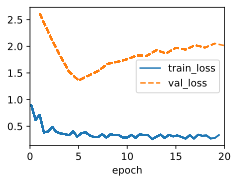

In [10]:
model = FTSE_RNN(num_inputs=1,num_hiddens=16)
trainer = d2l.Trainer(max_epochs=20,gradient_clip_val=1)
trainer.fit(model,data)